In [27]:
import sys,os
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path
import netCDF4 as netcdf
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from geopy.distance import distance


module_path = os.path.abspath(os.path.join('..'))
# module_path = os.path.join(os.path.abspath(os.path.join('..')),'wgpack')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
from wgpack.nav import get_bearing
from wgpack.timeconv import epoch2datetime64
from wgpack.config import seachest_data_dir
datadir  = os.path.join(os.path.dirname(seachest_data_dir),'ARCTERX2022/forecasts')

# Data service path
ds_folder = os.path.join(str(Path.home()),'src/lri-wgms-data-service')
if ds_folder not in sys.path:
    sys.path.insert(0, ds_folder)
from DataService import DataService

# ----------------------------------------------------------------------------------------------------------------------
# Inputs
# ----------------------------------------------------------------------------------------------------------------------
# vnam,channels,tw,prj =  'sv3-251','C0158P2JJTT','None','westpac'
vnam,channels,tw,prj =  'sv3-251','C0158P2JJTT',30,'westpac'
tw = None if tw == 'None' else tw


print('vehicle:',vnam)
print('project:',prj)

/Users/a1amador/src/wgpack
vehicle: sv3-251
project: westpac


In [28]:
# ----------------------------------------------------------------------------------------------------------------------
# Set start date according to the time window to be considered
now = datetime.utcnow()
if tw is not None:
    # use specified time window
    tst = now - pd.Timedelta(days=float(tw))
else:
    # use last 7 days
    # tst = now - pd.Timedelta(days=7)
    # use prescribed splash date
    tst = datetime(2022, 3, 9, 8, 0, 0, 0)

tspl = datetime(2022, 3, 9, 8, 0, 0, 0)
# tw
tst

datetime.datetime(2022, 2, 20, 19, 47, 28, 874084)

In [24]:
# ----------------------------------------------------------------------------------------------------------------------
# Read in vehicle location from Data Service
# try:
# instantiate data-service object
ds = DataService()
# To get report names
# print(ds.report_list)

start_date = tspl.strftime("%Y-%m-%dT%H:%M:%S.000Z")
end_date = now.strftime("%Y-%m-%dT%H:%M:%S.000Z")
out = ds.get_report_data('Telemetry 6 Report', start_date, end_date, [vnam])
# Convert to pandas dataframe
Telemdf = pd.json_normalize(out['report_data'][0]['vehicle_data']['recordData'])
# set timeStamp column as datetimeindex
Telemdf = Telemdf.set_index(pd.DatetimeIndex(Telemdf['gliderTimeStamp'].values))
Telemdf.drop(columns=['gliderTimeStamp'], inplace=True)
# sort index
Telemdf.sort_index(inplace=True)

# ----------------------------------------------------------------------------------------------------------------------
# Compute vehicle speed and direction (sog, cog)
# ----------------------------------------------------------------------------------------------------------------------
kt2mps = 0.514444
sog_lonlat,cog_lonlat=[],[]
cc=0
for index, row in Telemdf[:-1].iterrows():
    cc+=1
    p1 = (row['latitude'],row['longitude'])
    p2 = (Telemdf.iloc[cc]['latitude'],Telemdf.iloc[cc]['longitude'])
    delt = (Telemdf.index[cc]-index)/np.timedelta64(1, 's')
    sogtmp = distance(p1,p2).m/delt if delt>0 else np.nan
    sog_lonlat.append(sogtmp)
    cog_lonlat.append(get_bearing(p1,p2))

# not sure if these are trustworthy
speedOverGround = Telemdf['speedOverGround'].values*kt2mps
gliderSpeed = Telemdf['gliderSpeed'].values*kt2mps


In [25]:
# ----------------------------------------------------------------------------------------------------------------------
# LOAD Sea Glider data
SGdatadir  = os.path.join(os.path.dirname(seachest_data_dir),'ARCTERX2022/sg526')
# filename = 'sg526_ARCTERX_1.0m_up_and_down_profile.nc'
filename = 'sg526_ARCTERX_timeseries.nc'
SGfnam    = os.path.join(SGdatadir,filename)
SG_data = netcdf.Dataset(SGfnam)
# Sea Glider time
# ttSG = pd.to_datetime(epoch2datetime64(SG_data['start_time'][:]))
ttSG = pd.to_datetime(epoch2datetime64(SG_data['end_time'][:]))
# SG time index associated with start time
iiaSG = np.abs(ttSG - tst).argmin()
# crop data
SG_stlon = SG_data['start_longitude'][iiaSG:]
SG_stlat = SG_data['start_latitude'][iiaSG:]
SG_enlon = SG_data['end_longitude'][iiaSG:]
SG_enlat = SG_data['end_latitude'][iiaSG:]
ttSG = ttSG[iiaSG:]


In [69]:
print(SG_data.variables)

# SG_data['aa4831_O2']

# # SG_data['temperature_raw']
# # len(SG_data['depth'][:])
# len(SG_data['temperature_raw'])
# SG_data['ctd_depth']
# # 95317

# plt.plot(SG_data['temperature_raw'][:],SG_data['ctd_depth'][:])

# SG_data['ctd_time'][:]

# SG_data['ctd_depth'][:]


{'sg_data_point_dive_number': <class 'netCDF4._netCDF4.Variable'>
int32 sg_data_point_dive_number(sg_data_point)
    comment: Dive number for given sg_data_point observation
unlimited dimensions: 
current shape = (111420,)
filling on, default _FillValue of -2147483647 used, 'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(sg_data_point)
    standard_name: time
    axis: T
    units: seconds since 1970-1-1 00:00:00
    comment: Time of the sample in GMT epoch format
unlimited dimensions: 
current shape = (111420,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'pressure': <class 'netCDF4._netCDF4.Variable'>
float64 pressure(sg_data_point)
    units: dbar
    comment: Uncorrected sea-water pressure at pressure sensor
unlimited dimensions: 
current shape = (111420,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'depth': <class 'netCDF4._netCDF4.Variable'>
float64 depth(sg_data_point)
    standard_name: depth
    axis: Z
    units: meters
    positive

In [33]:
# ----------------------------------------------------------------------------------------------------------------------
# LOAD ROMS data

# get mixed layer velocities near the Wave Glider
sub_depth = 100

import pyproj
# Reference: What UTM Zone am I in ?
# https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#
myproj = pyproj.Proj(proj='utm',zone=55,ellps='WGS84', units='m', preserve_units=False)

# ttsim = []
ROMS_data_lst=[]
u_sl_lst,v_sl_lst=[],[]
rel_vor = []
for ii in np.flip(range((now-tst).days)):
    print(ii)
    tsti = now - pd.Timedelta(days=float(ii))
    try:
        # filename
        filename = 'ROMS_Guam_' + tsti.strftime('%Y%m%d') + '.ncd'
        dfnam    = os.path.join(datadir,filename)
        print(dfnam)
        init_str = tsti.strftime('%Y-%m-%d') + ' UTC'
        # Read-in data
        ROMS_data = netcdf.Dataset(dfnam)
        ROMS_data_lst.append(ROMS_data)
        
        # extract coordinates
        iia_lat,iia_lon = 0,0
        iib_lat = min(len(ROMS_data['lon'][:]),len(ROMS_data['lat'][:]))
        iib_lon = min(len(ROMS_data['lon'][:]),len(ROMS_data['lat'][:]))
        lon_ROMS = ROMS_data['lon'][iia_lon:iib_lon]
        lat_ROMS = ROMS_data['lat'][iia_lat:iib_lat]

        # project to UTM to convert to meters
        xy_lst = [myproj(x, y) for x,y in zip(lon_ROMS[:], lat_ROMS[:])]
        xUTM = np.array([x[0] for x in xy_lst])
        yUTM = np.array([y[-1] for y in xy_lst])
        dxx, dyy = np.meshgrid(np.gradient(xUTM), np.gradient(yUTM))
        
        # find runs for day 1
        print(ROMS_data['time'].units)
        match = re.search(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', ROMS_data['time'].units)
        basetime = pd.to_datetime(datetime.strptime(match.group(), '%Y-%m-%d %H:%M:%S').date())
        ttsim = []
        for hh in ROMS_data['time'][:]:
            ttsim.append(basetime+pd.Timedelta(hours=hh))
        ttsim = pd.to_datetime(ttsim)
        # find runs for day 1
        iit=8
        # get mixed layer velocities near the Wave Glider
        iida = ROMS_data['depth'][:]<(sub_depth)        
        # get average velocity data
        u_sl_lst.append(np.mean(ROMS_data['u'][:iit, iida, iia_lat:iib_lat, iia_lon:iib_lon],axis=(0, 1)))
        v_sl_lst.append(np.mean(ROMS_data['v'][:iit, iida, iia_lat:iib_lat, iia_lon:iib_lon],axis=(0, 1)))

        # compute relative vorticity
        ui = np.mean(ROMS_data['u'][:iit, iida, iia_lat:iib_lat, iia_lon:iib_lon],axis=(1))
        vi = np.mean(ROMS_data['v'][:iit, iida, iia_lat:iib_lat, iia_lon:iib_lon],axis=(1))
#         rel_vor = np.gradient(vi,axis=2)/dxx - np.gradient(ui,axis=1)/dyy
#         rel_vor.append(np.gradient(vi,axis=2)/dxx - np.gradient(ui,axis=1)/dyy)
        rel_vor.append(np.mean(np.gradient(vi,axis=2)/dxx - np.gradient(ui,axis=1)/dyy,axis=0))
        
    except FileNotFoundError as err:
        print(err)

# convert to array
u_sl_lst = np.array(u_sl_lst)
v_sl_lst = np.array(v_sl_lst)
rel_vor  = np.array(rel_vor)
# Earth's rotation rate
Om = 2*np.pi/(24*3600)
# planetrary vorticity (Coriolis parameter)
f = 2*Om*np.sin(np.deg2rad(np.mean(lat_ROMS)))
Ro = rel_vor/f

# average in time (days)
u_sl = np.mean(u_sl_lst,axis=0)
v_sl = np.mean(v_sl_lst,axis=0)
# compute velocity magnitude
vel_mag = np.sqrt(u_sl**2+v_sl**2)

print(rel_vor.shape)
print(ui.shape)


29
/Volumes/cordc-data/PROJECTS/ARCTERX2022/forecasts/ROMS_Guam_20220221.ncd
[Errno 2] No such file or directory: b'/Volumes/cordc-data/PROJECTS/ARCTERX2022/forecasts/ROMS_Guam_20220221.ncd'
28
/Volumes/cordc-data/PROJECTS/ARCTERX2022/forecasts/ROMS_Guam_20220222.ncd
[Errno 2] No such file or directory: b'/Volumes/cordc-data/PROJECTS/ARCTERX2022/forecasts/ROMS_Guam_20220222.ncd'
27
/Volumes/cordc-data/PROJECTS/ARCTERX2022/forecasts/ROMS_Guam_20220223.ncd
hours since 2015-04-15 00:00:00.000 UTC
26
/Volumes/cordc-data/PROJECTS/ARCTERX2022/forecasts/ROMS_Guam_20220224.ncd
hours since 2015-04-15 00:00:00.000 UTC
25
/Volumes/cordc-data/PROJECTS/ARCTERX2022/forecasts/ROMS_Guam_20220225.ncd
hours since 2015-04-15 00:00:00.000 UTC
24
/Volumes/cordc-data/PROJECTS/ARCTERX2022/forecasts/ROMS_Guam_20220226.ncd
hours since 2015-04-15 00:00:00.000 UTC
23
/Volumes/cordc-data/PROJECTS/ARCTERX2022/forecasts/ROMS_Guam_20220227.ncd
hours since 2015-04-15 00:00:00.000 UTC
22
/Volumes/cordc-data/PROJECTS/A

In [5]:
# import pyproj
# # Reference: What UTM Zone am I in ?
# # https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#

# # ROMS_data['u'][:iit, iida, iia_lat:iib_lat, iia_lon:iib_lon].shape
# np.mean(ROMS_data['u'][:iit, iida, iia_lat:iib_lat, iia_lon:iib_lon],axis=(1))
# np.mean(ROMS_data['v'][:iit, iida, iia_lat:iib_lat, iia_lon:iib_lon],axis=(1)).shape

# myproj = pyproj.Proj(proj='utm',zone=55,ellps='WGS84', units='m', preserve_units=False)
# xy_lst = [myproj(x, y) for x,y in zip(lon_ROMS[:], lat_ROMS[:])]
# xUTM = np.array([x[0] for x in xy_lst])
# yUTM = np.array([y[-1] for y in xy_lst])


# # plt.plot(np.diff(yUTM),'r')
# # plt.plot(np.gradient(yUTM),'--r')
# # plt.plot(np.diff(xUTM),'b')

# # cf = plt.contourf(xUTM, yUTM, vel_mag, levels=levels, cmap='jet', extend="both")
# # len(yUTM)
# # vel_mag.shape
# print(len(lon_ROMS[:]))
# print(len(lat_ROMS[:]))

# # np.gradient(f, xUTM)
# ui = np.mean(ROMS_data['u'][:iit, iida, iia_lat:iib_lat, iia_lon:iib_lon],axis=(1))
# vi = np.mean(ROMS_data['v'][:iit, iida, iia_lat:iib_lat, iia_lon:iib_lon],axis=(1))

# dxx, dyy = np.meshgrid(np.gradient(xUTM), np.gradient(yUTM))
# # np.gradient(ui, xx)

# # (time, depth, lat, lon)
# rel_vor = np.gradient(vi,axis=2)/dxx - np.gradient(ui,axis=1)/dyy

# cf = plt.contourf(xUTM, yUTM, np.nanmean(rel_vor,axis=0), levels=100, cmap='bwr', extend="both")

In [34]:
# ROMS_data.variables
# ROMS_data['depth'][:]
Ro.shape

(27, 221, 221)

/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


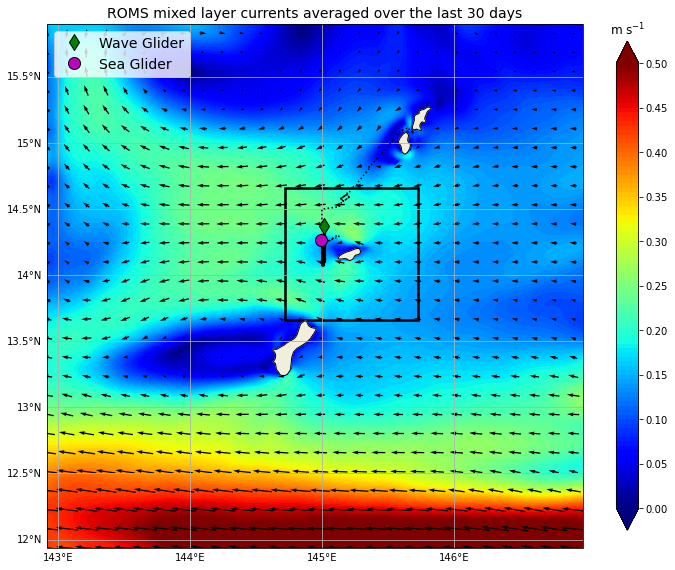

In [31]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches

# latest sea-glider surfacing
SGlon = SG_enlon[-1]
SGlat = SG_enlat[-1]
# Rota Island coordinates
Rlat,Rlon = 14.160614, 145.221402

# plot config
fntsz = 14
isub = 8
levels = np.linspace(0,0.50,101)


fig, ax = plt.subplots(figsize=(12,12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])


ax.set_extent([lon_ROMS.min(), lon_ROMS.max(), lat_ROMS.min(), lat_ROMS.max()])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = ax.contourf(lon_ROMS, lat_ROMS, vel_mag, levels=levels, cmap='jet', extend="both",
                 transform=ccrs.PlateCarree())

# add land and coastlines
ax.add_feature(LAND)
ax.coastlines(resolution='10m')

# plot Wave Glider location
ax.plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
ax.plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label='Wave Glider')
# plot Sea Glider latest location
ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
# legend
ax.legend(fontsize=fntsz,loc='upper left')
# tick params
ax.tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
Q = ax.quiver(lon_ROMS[::isub], lat_ROMS[::isub], u_sl[::isub,::isub], v_sl[::isub,::isub], pivot='middle')

# plot box around Rota island
# ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
ax.add_patch(mpatches.Rectangle(xy=[Rlon-0.5, Rlat-0.5], width=1, height=1,
                                    facecolor='None',
                                    alpha=1,
                                    edgecolor='k',
                                    lw = 2.5,
                                    transform=ccrs.PlateCarree())
            )


# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75,ticks=np.linspace(0,0.50,11))
cb.ax.set_title('m s$^{-1}$')
ax.set_title('ROMS mixed layer currents averaged over the last ' + str(tw) + ' days',fontsize=fntsz);


/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


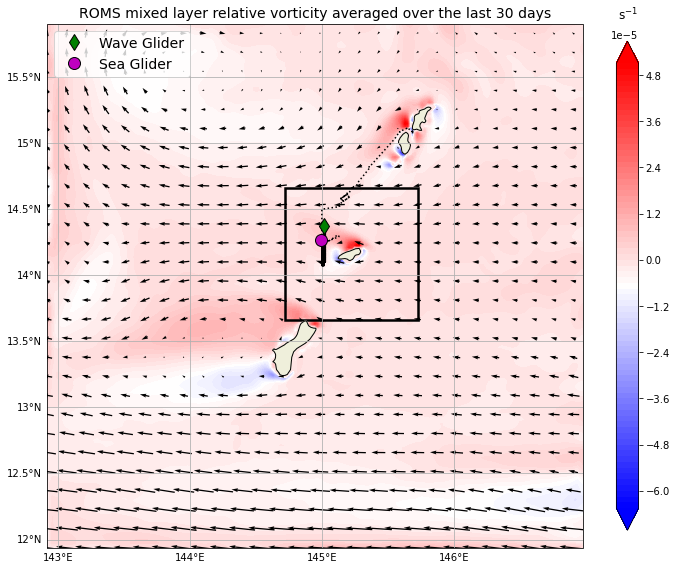

In [35]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches

# latest sea-glider surfacing
SGlon = SG_enlon[-1]
SGlat = SG_enlat[-1]
# Rota Island coordinates
Rlat,Rlon = 14.160614, 145.221402

# plot config
fntsz = 14
isub = 8
levels = 101
# levels = 101np.linspace(0,0.50,101)


fig, ax = plt.subplots(figsize=(12,12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])


ax.set_extent([lon_ROMS.min(), lon_ROMS.max(), lat_ROMS.min(), lat_ROMS.max()])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
# cf = ax.contourf(lon_ROMS, lat_ROMS, rel_vor[-2], levels=levels, cmap='bwr', extend="both",
#                  transform=ccrs.PlateCarree())
cf = ax.contourf(lon_ROMS, lat_ROMS, np.mean(rel_vor,axis=(0)), levels=levels, cmap='bwr', extend="both",
                 transform=ccrs.PlateCarree())

# add land and coastlines
ax.add_feature(LAND)
ax.coastlines(resolution='10m')

# plot Wave Glider location
ax.plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
ax.plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label='Wave Glider')
# plot Sea Glider latest location
ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
# legend
ax.legend(fontsize=fntsz,loc='upper left')
# tick params
ax.tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
Q = ax.quiver(lon_ROMS[::isub], lat_ROMS[::isub], u_sl[::isub,::isub], v_sl[::isub,::isub], pivot='middle')

# plot box around Rota island
# ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
ax.add_patch(mpatches.Rectangle(xy=[Rlon-0.5, Rlat-0.5], width=1, height=1,
                                    facecolor='None',
                                    alpha=1,
                                    edgecolor='k',
                                    lw = 2.5,
                                    transform=ccrs.PlateCarree())
            )


# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75)
cb.ax.set_title('s$^{-1}$\n')
ax.set_title('ROMS mixed layer relative vorticity averaged over the last ' + str(tw) + ' days',fontsize=fntsz);


/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


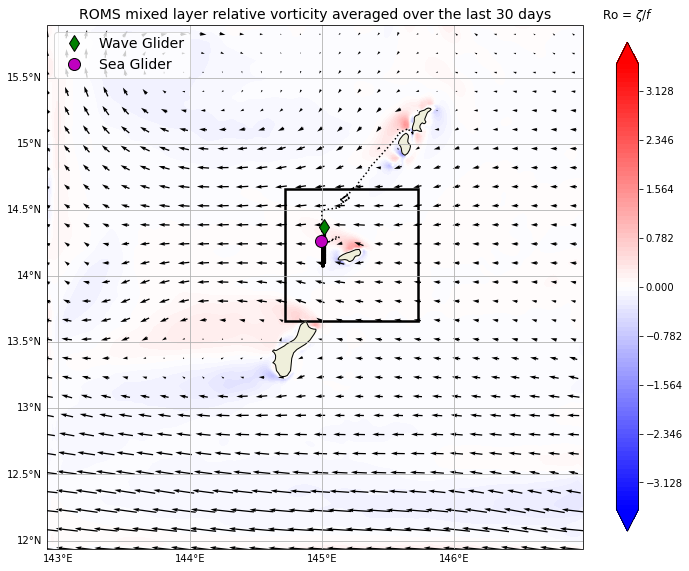

In [38]:
# non-dimensional vorticity
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches

# latest sea-glider surfacing
SGlon = SG_enlon[-1]
SGlat = SG_enlat[-1]
# Rota Island coordinates
Rlat,Rlon = 14.160614, 145.221402

# plot config
fntsz = 14
isub = 8
levels = 101
cL = np.round(np.max(np.abs(Ro)), 6)
levels = np.linspace(-cL,cL,101)


fig, ax = plt.subplots(figsize=(12,12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])


ax.set_extent([lon_ROMS.min(), lon_ROMS.max(), lat_ROMS.min(), lat_ROMS.max()])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
# cf = ax.contourf(lon_ROMS, lat_ROMS, rel_vor[-2], levels=levels, cmap='bwr', extend="both",
#                  transform=ccrs.PlateCarree())
cf = ax.contourf(lon_ROMS, lat_ROMS, np.mean(Ro,axis=(0)), levels=levels, cmap='bwr', extend="both",
                 transform=ccrs.PlateCarree())

# add land and coastlines
ax.add_feature(LAND)
ax.coastlines(resolution='10m')

# plot Wave Glider location
ax.plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
ax.plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label='Wave Glider')
# plot Sea Glider latest location
ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
# legend
ax.legend(fontsize=fntsz,loc='upper left')
# tick params
ax.tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
Q = ax.quiver(lon_ROMS[::isub], lat_ROMS[::isub], u_sl[::isub,::isub], v_sl[::isub,::isub], pivot='middle')

# plot box around Rota island
# ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
ax.add_patch(mpatches.Rectangle(xy=[Rlon-0.5, Rlat-0.5], width=1, height=1,
                                    facecolor='None',
                                    alpha=1,
                                    edgecolor='k',
                                    lw = 2.5,
                                    transform=ccrs.PlateCarree())
            )


# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75)
cb.ax.set_title('Ro = $\zeta/f$\n')
ax.set_title('ROMS mixed layer relative vorticity averaged over the last ' + str(tw) + ' days',fontsize=fntsz);


In [40]:
# iia_lat,iia_lon = 0,0
# iib_lat,iib_lon = -1,-1
# np.nanmean(np.array(sog_lonlat))*3600/1000
dx = 1

# find nearest ROMS point to Rota Island location
iilonR = np.abs(ROMS_data['lon'][:]-Rlon).argmin()
iilatR = np.abs(ROMS_data['lat'][:]-Rlat).argmin()

iia_lon = np.abs(ROMS_data['lon'][:]-(Rlon-dx/2)).argmin()
iib_lon = np.abs(ROMS_data['lon'][:]-(Rlon+dx/2)).argmin()
# iia_lat = np.abs(ROMS_data['lat'][:]-(Rlat-dx/2)).argmin()
# iib_lat = np.abs(ROMS_data['lat'][:]-(Rlat+dx/2)).argmin()
nn = (iib_lon-iia_lon)
iia_lat = int(iilatR-nn/2)
iib_lat = int(iilatR+nn/2)

print(iib_lon-iia_lon)
print(iib_lat-iia_lat)


54
54


/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


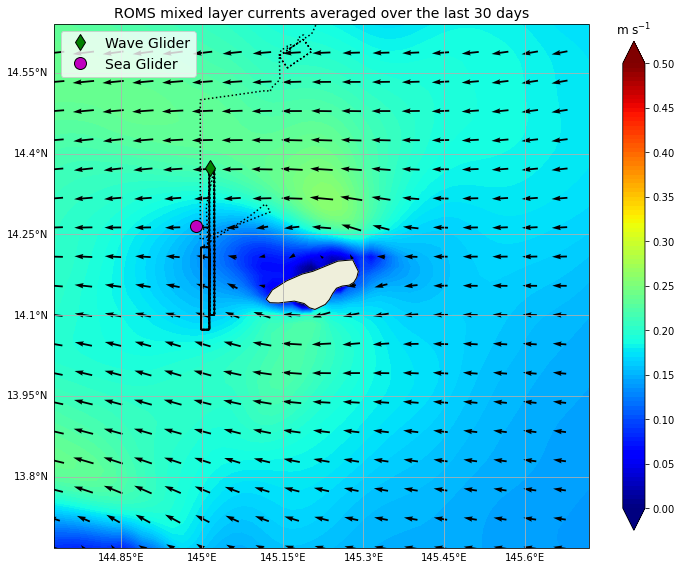

In [41]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches

# latest sea-glider surfacing

SGlon = SG_enlon[-1]
SGlat = SG_enlat[-1]
fntsz = 14

isub = 3
levels = np.linspace(0,0.50,101)


fig, ax = plt.subplots(figsize=(12,12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])


ax.set_extent([lon_ROMS[iia_lon].min(), lon_ROMS[iib_lon].max(), lat_ROMS[iia_lat].min(), lat_ROMS[iib_lat].max()])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = ax.contourf(lon_ROMS, lat_ROMS, vel_mag, levels=levels, cmap='jet', extend="both",
                 transform=ccrs.PlateCarree())

# add land and coastlines
ax.add_feature(LAND)
ax.coastlines(resolution='10m')

# plot Wave Glider location
ax.plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
ax.plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label='Wave Glider')
# plot Sea Glider latest location
ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
# legend
ax.legend(fontsize=fntsz,loc='upper left')
# tick params
ax.tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
# Q = ax.quiver(lon_ROMS[::isub], lat_ROMS[::isub], u_sl[::isub,::isub], v_sl[::isub,::isub], pivot='middle')
Q = ax.quiver(lon_ROMS[iia_lon:iib_lon:isub], lat_ROMS[iia_lat:iib_lat:isub], 
              u_sl[iia_lat:iib_lat:isub,iia_lon:iib_lon:isub], v_sl[iia_lat:iib_lat:isub,iia_lon:iib_lon:isub], pivot='middle')
#      coordinates: time_run time depth lat lon 

# plot box around Rota island
# ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
ax.add_patch(mpatches.Rectangle(xy=[Rlon-0.5, Rlat-0.5], width=1, height=1,
                                    facecolor='None',
                                    alpha=1,
                                    edgecolor='k',
                                    lw = 2.5,
                                    transform=ccrs.PlateCarree())
            )


# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75,ticks=np.linspace(0,0.50,11))
cb.ax.set_title('m s$^{-1}$')
ax.set_title('ROMS mixed layer currents averaged over the last ' + str(tw) + ' days',fontsize=fntsz);



/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


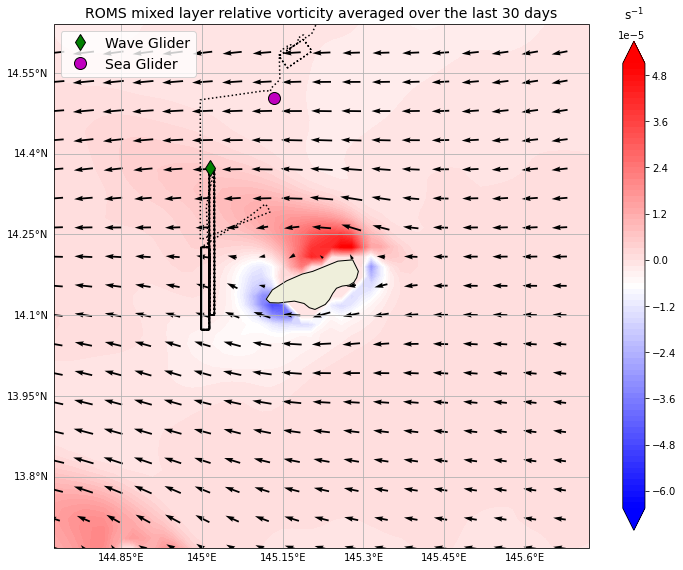

In [42]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches

# latest sea-glider surfacing

SGlon = 145 + 08.02/60
SGlat = 14 + 30.16/60
fntsz = 14

isub = 3
# levels = np.linspace(0,0.50,101)
levels = 101


fig, ax = plt.subplots(figsize=(12,12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])


ax.set_extent([lon_ROMS[iia_lon].min(), lon_ROMS[iib_lon].max(), lat_ROMS[iia_lat].min(), lat_ROMS[iib_lat].max()])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = ax.contourf(lon_ROMS, lat_ROMS, np.mean(rel_vor,axis=(0)), levels=levels, cmap='bwr', extend="both",
                 transform=ccrs.PlateCarree())

# add land and coastlines
ax.add_feature(LAND)
ax.coastlines(resolution='10m')

# plot Wave Glider location
ax.plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
ax.plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label='Wave Glider')
# plot Sea Glider latest location
ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
# legend
ax.legend(fontsize=fntsz,loc='upper left')
# tick params
ax.tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
# Q = ax.quiver(lon_ROMS[::isub], lat_ROMS[::isub], u_sl[::isub,::isub], v_sl[::isub,::isub], pivot='middle')
Q = ax.quiver(lon_ROMS[iia_lon:iib_lon:isub], lat_ROMS[iia_lat:iib_lat:isub], 
              u_sl[iia_lat:iib_lat:isub,iia_lon:iib_lon:isub], v_sl[iia_lat:iib_lat:isub,iia_lon:iib_lon:isub], pivot='middle')
#      coordinates: time_run time depth lat lon 

# plot box around Rota island
# ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
ax.add_patch(mpatches.Rectangle(xy=[Rlon-0.5, Rlat-0.5], width=1, height=1,
                                    facecolor='None',
                                    alpha=1,
                                    edgecolor='k',
                                    lw = 2.5,
                                    transform=ccrs.PlateCarree())
            )


# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75)
cb.ax.set_title('s$^{-1}$\n')
ax.set_title('ROMS mixed layer relative vorticity averaged over the last ' + str(tw) + ' days',fontsize=fntsz);



/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


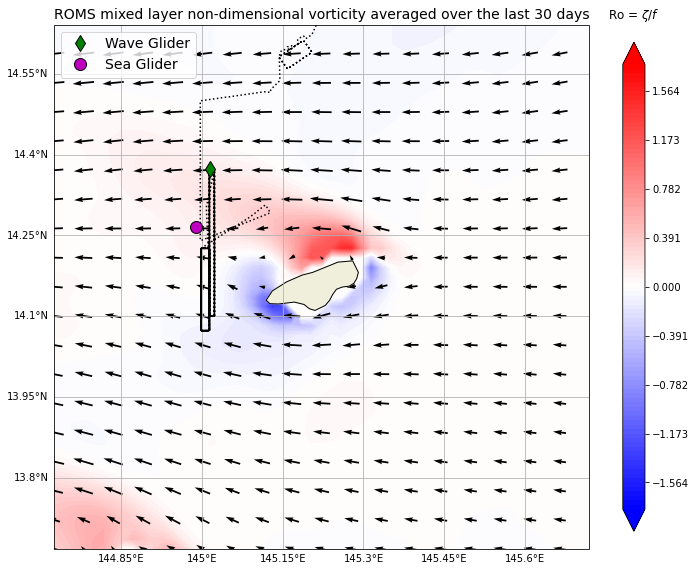

In [47]:
# non-dimensional vorticity
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches

# latest sea-glider surfacing

SGlon = SG_enlon[-1]
SGlat = SG_enlat[-1]
fntsz = 14

isub = 3
cL = np.round(np.max(np.abs(Ro))/2, 6)
levels = np.linspace(-cL,cL,101)


fig, ax = plt.subplots(figsize=(12,12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])


ax.set_extent([lon_ROMS[iia_lon].min(), lon_ROMS[iib_lon].max(), lat_ROMS[iia_lat].min(), lat_ROMS[iib_lat].max()])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = ax.contourf(lon_ROMS, lat_ROMS, np.mean(Ro,axis=(0)), levels=levels, cmap='bwr', extend="both",
                 transform=ccrs.PlateCarree())

# add land and coastlines
ax.add_feature(LAND)
ax.coastlines(resolution='10m')

# plot Wave Glider location
ax.plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
ax.plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label='Wave Glider')
# plot Sea Glider latest location
ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
# legend
ax.legend(fontsize=fntsz,loc='upper left')
# tick params
ax.tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
# Q = ax.quiver(lon_ROMS[::isub], lat_ROMS[::isub], u_sl[::isub,::isub], v_sl[::isub,::isub], pivot='middle')
Q = ax.quiver(lon_ROMS[iia_lon:iib_lon:isub], lat_ROMS[iia_lat:iib_lat:isub], 
              u_sl[iia_lat:iib_lat:isub,iia_lon:iib_lon:isub], v_sl[iia_lat:iib_lat:isub,iia_lon:iib_lon:isub], pivot='middle')
#      coordinates: time_run time depth lat lon 

# plot box around Rota island
# ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
ax.add_patch(mpatches.Rectangle(xy=[Rlon-0.5, Rlat-0.5], width=1, height=1,
                                    facecolor='None',
                                    alpha=1,
                                    edgecolor='k',
                                    lw = 2.5,
                                    transform=ccrs.PlateCarree())
            )


# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75)
cb.ax.set_title('Ro = $\zeta/f$\n')
ax.set_title('ROMS mixed layer non-dimensional vorticity averaged over the last ' + str(tw) + ' days',fontsize=fntsz);



/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


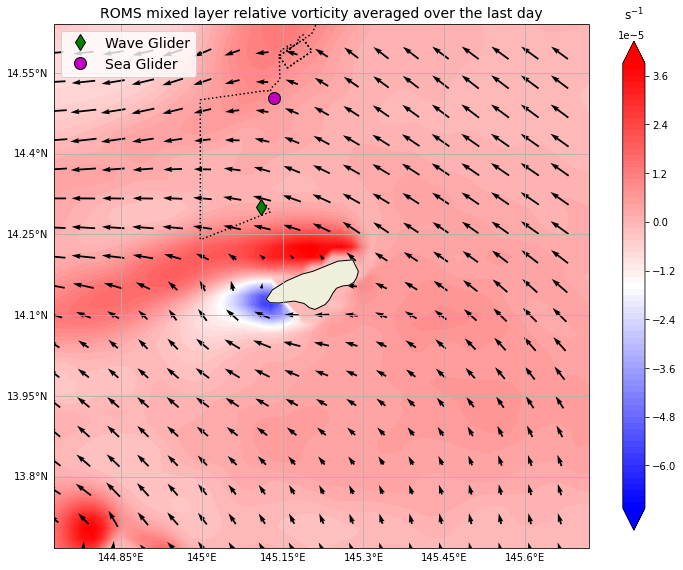

In [12]:
# Animation of Relative vorticity

import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches

# latest sea-glider surfacing

SGlon = 145 + 08.02/60
SGlat = 14 + 30.16/60
fntsz = 14

isub = 3
levels = 101


fig, ax = plt.subplots(figsize=(12,12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])


ax.set_extent([lon_ROMS[iia_lon].min(), lon_ROMS[iib_lon].max(), lat_ROMS[iia_lat].min(), lat_ROMS[iib_lat].max()])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = ax.contourf(lon_ROMS, lat_ROMS, rel_vor[-1], levels=levels, cmap='bwr', extend="both",
                 transform=ccrs.PlateCarree())

# add land and coastlines
ax.add_feature(LAND)
ax.coastlines(resolution='10m')

# plot Wave Glider location
ax.plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
ax.plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label='Wave Glider')
# plot Sea Glider latest location
ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
# legend
ax.legend(fontsize=fntsz,loc='upper left')
# tick params
ax.tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
# Q = ax.quiver(lon_ROMS[::isub], lat_ROMS[::isub], u_sl[::isub,::isub], v_sl[::isub,::isub], pivot='middle')
Q = ax.quiver(lon_ROMS[iia_lon:iib_lon:isub], lat_ROMS[iia_lat:iib_lat:isub], 
              np.mean(ui[:,iia_lat:iib_lat:isub,iia_lon:iib_lon:isub],axis=0), 
              np.mean(vi[:,iia_lat:iib_lat:isub,iia_lon:iib_lon:isub],axis=0),
              pivot='middle')
#      coordinates: time_run time depth lat lon 



# plot box around Rota island
# ax.plot(SGlon,SGlat,'mo',mec='k',ms=12, label='Sea Glider')
ax.add_patch(mpatches.Rectangle(xy=[Rlon-0.5, Rlat-0.5], width=1, height=1,
                                    facecolor='None',
                                    alpha=1,
                                    edgecolor='k',
                                    lw = 2.5,
                                    transform=ccrs.PlateCarree())
            )


# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75)
cb.ax.set_title('s$^{-1}$\n')
ax.set_title('ROMS mixed layer relative vorticity averaged over the last day',fontsize=fntsz);

